In [1]:
import pandas as pd
import numpy as np

In [2]:
def entropy(p):
    return np.sum(p * np.log2(p + 1e-6), axis=-1)

In [3]:
random_state = 1

In [4]:
df = pd.read_csv('data.csv', index_col=0)
df.head()

,Code,Date
0,EYIW2W,1999-11-09
1,E2IY22,1999-11-09
2,EGIF22,1999-11-09
3,E2IWQW,1999-11-09
4,E2IWQW,1999-11-09


In [5]:
df.describe()

,Code,Date
count,15703,15703
unique,1524,2411
top,E2IW4G,2016-11-09
freq,408,28


Elimizdeki ürün kodlarının kaç kere satıldığını, hangi aylarda satıldığını ve ne sıklıkla satıldığını kaydediyoruz.

In [6]:
particles = df.groupby('Code')
code_to_vals = {}
code_to_lens = {}
code_to_means = {}
code_to_months = {}
mx_day = 0 
for (code, particle) in particles:
    if len(particle) < 10: # On kereden az satılan ürünleri alma.
        continue
        
    # Ürünün satıldığı ayların vektörünü çıkarıp, normalize ediyoruz.
    # Böylelikle ürünün hangi aylarda satıldığının dağılımını buluyoruz.
    months = np.zeros(12,)
    dates = pd.to_datetime(particle.Date.values)
    month_idxs = dates.month - 1
    for idx in month_idxs:
        months[idx] += 1
    month_prob = months / months.sum()
    
    # Ürünün iki satışı arasında geçen sürenin vektörünü çıkarıyoruz.
    difference_series = (dates[1:] - dates[:-1]).days
    
    # Indexing
    code_to_months[code] = month_prob
    code_to_vals[code] = difference_series
    code_to_lens[code] = len(difference_series)
    code_to_means[code] = np.array(difference_series).mean()
    
    # Maksimum satış süresini histogramda kullanmak üzere tutuyoruz.
    mx_day = max(difference_series.max(), mx_day)

In [7]:
mx_day, np.log10(mx_day)

(5148, 3.7116385382323491)

In [8]:
code_to_hist = {}
code_to_entropy = {}
interval = np.logspace(0, np.log10(mx_day), 20)
for code, series in code_to_vals.items():
    # Satış değerlerinin histogramını tutuyoruz.
    # Entropiyi ürün satışındaki düzensizliği ölçmek içini kullandık.
    bins, _ = np.histogram(series + 1, bins=interval)
    probabilities = 1. * bins / bins.sum()
    code_to_hist[code] = probabilities
    code_to_entropy[code] = entropy(probabilities)

In [9]:
from sklearn.decomposition import PCA, LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

[ 0.11111111  0.          0.          0.          0.          0.
  0.11111111  0.          0.11111111  0.11111111  0.22222222  0.11111111
  0.11111111  0.          0.          0.          0.          0.
  0.11111111]


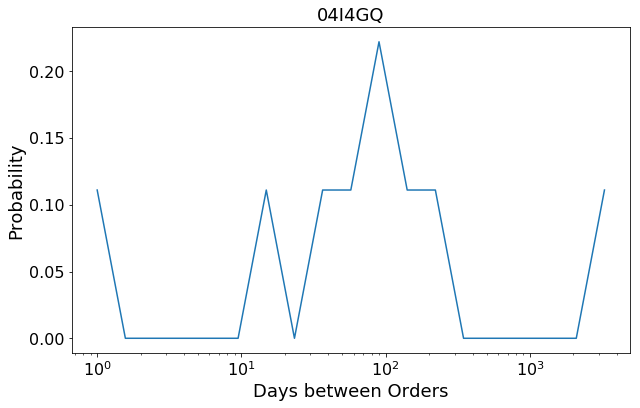

In [10]:
# 04I4GQ ürününün satış histogramını görselleştirelim.
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.semilogx(_[:-1], code_to_hist['04I4GQ'])
ax.tick_params(labelsize=16)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Days between Orders', fontsize=18)
ax.set_title('04I4GQ', fontsize=18)
print(code_to_hist['04I4GQ'])

In [11]:
# Satış verilerinin histogramımnı alalım.
tfd = PCA(n_components=2).fit_transform(np.array(list(code_to_hist.values())))

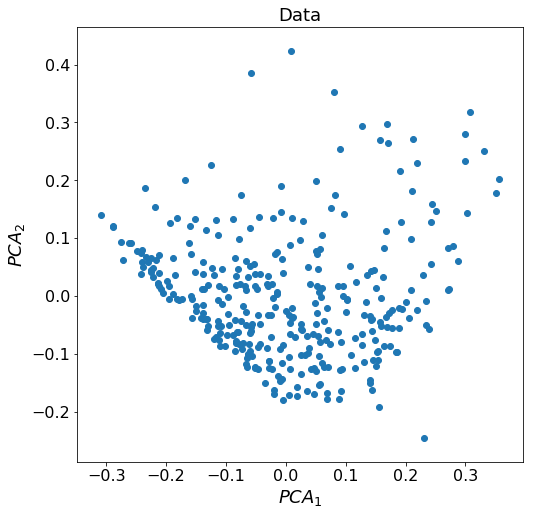

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_title('Data', fontsize=18)
ax.scatter(tfd[:, 0], tfd[:, 1])
ax.set_xlabel('${PCA}_1$', fontsize=18)
ax.set_ylabel('${PCA}_2$', fontsize=18)
ax.tick_params(labelsize=16)

In [13]:
np.where(tfd[:, 1] > 0.1), np.where(tfd[:, 1] < -0.1) # Uç PCA2 değerlerinin indexlerini aldık.

((array([  2,  19,  22,  33,  40,  57,  66,  86,  87,  91,  94,  95, 104,
         110, 136, 141, 144, 145, 146, 148, 149, 167, 182, 191, 194, 195,
         202, 203, 208, 210, 211, 219, 225, 227, 235, 243, 244, 251, 256,
         258, 266, 288, 291, 292, 303, 307, 310, 313, 314, 319, 334, 335]),),
 (array([  4,   6,  34,  45,  47,  59,  60,  65,  69,  70,  74,  75,  79,
          84,  88,  92,  98, 102, 106, 118, 120, 131, 133, 140, 153, 155,
         158, 159, 161, 164, 166, 172, 175, 177, 178, 185, 186, 187, 189,
         192, 205, 218, 220, 221, 224, 226, 228, 232, 234, 238, 242, 275,
         277, 297, 317, 321, 333]),))

In [14]:
keys = list(code_to_hist.keys())
print('PCA high Y: ', keys[22], keys[86], keys[91], )
print('PCA low Y: ', keys[6], keys[45], keys[65])

PCA high Y:  E2I2YF E2II2Y E2IIIR
PCA low Y:  5CWMSR E2I8IW E2IFRI


In [15]:
# Uç değerlerin indexleri
highs_y, = np.where(tfd[:, 1] > 0.1)
lows_y, = np.where(tfd[:, 1] < -0.1) 
highs_x, = np.where(tfd[:, 0] > 0.1)
lows_x, = np.where(tfd[:, 0] < -0.1) 

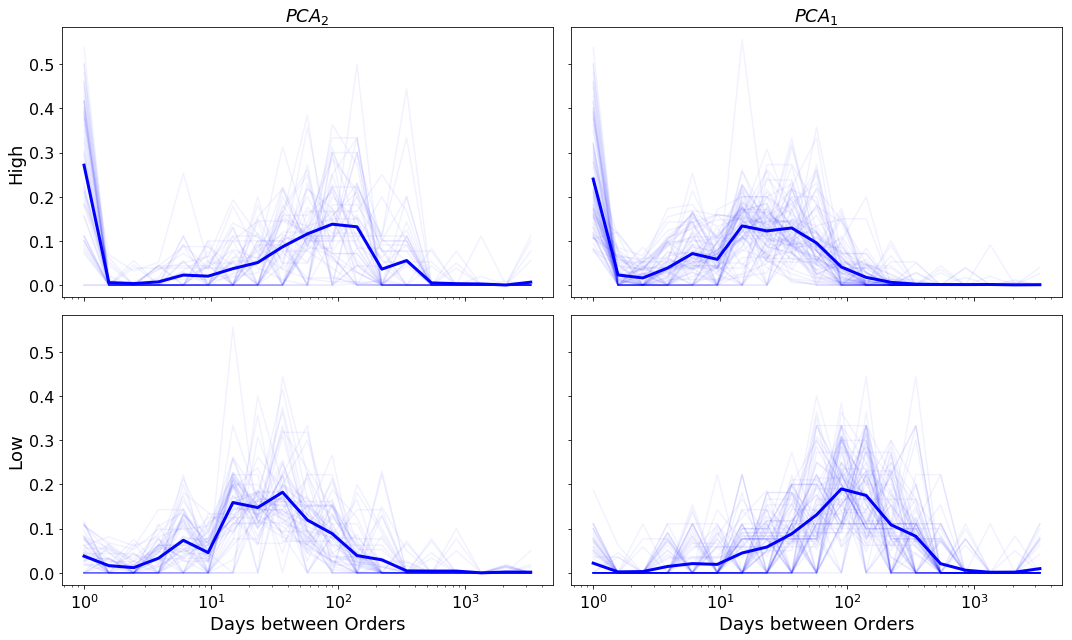

In [16]:
# Uç değerlerin histogramlarını önce saydam olarak arkaplana çizdirdik.
# Sonra her uç bölgenin ortalama histogramını kalın olarak önplana çizdirdik.
# Böylelikle, PCA boyutlarının neyi gösterdiğini anlamlandırabiliriz.

fig, axes = plt.subplots(2, 2, figsize=(15, 9), sharex=True, sharey=True)
axes[0, 0].set_title('${PCA}_2$', fontsize=18)
axes[0, 1].set_title('${PCA}_1$', fontsize=18)
axes[0, 0].set_ylabel('High', fontsize=18)
axes[1, 0].set_ylabel('Low', fontsize=18)
[ax.set_xlabel('Days between Orders', fontsize=18) for ax in axes[1, :]]
highy_mean = np.zeros((19,))
lowy_mean = np.zeros((19,))
highx_mean = np.zeros((19,))
lowx_mean = np.zeros((19,))

for high in highs_y:
    vec = code_to_hist[keys[high]]
    highy_mean += vec / len(highs_y)
    axes[0, 0].semilogx(_[:-1], vec, c='b', alpha=0.05)
axes[0, 0].semilogx(_[:-1], highy_mean, c='b', alpha=1, linewidth=3)

for low in lows_y:
    vec = code_to_hist[keys[low]]
    lowy_mean += vec / len(lows_y)
    axes[1, 0].semilogx(_[:-1], vec, c='b', alpha=0.05)
axes[1, 0].semilogx(_[:-1], lowy_mean, c='b', alpha=1, linewidth=3)

for high in highs_x:
    vec = code_to_hist[keys[high]]
    highx_mean += vec / len(highs_x)
    axes[0, 1].semilogx(_[:-1], vec, c='b', alpha=0.05)
axes[0, 1].semilogx(_[:-1], highx_mean, c='b', alpha=1, linewidth=3)

for low in lows_x:
    vec = code_to_hist[keys[low]]
    lowx_mean += vec / len(lows_x)
    axes[1, 1].semilogx(_[:-1], vec, c='b', alpha=0.05)
axes[1, 1].semilogx(_[:-1], lowx_mean, c='b', alpha=1, linewidth=3)
__ = [ax.tick_params(labelsize=16) for ax in axes.reshape(-1)]
fig.tight_layout()

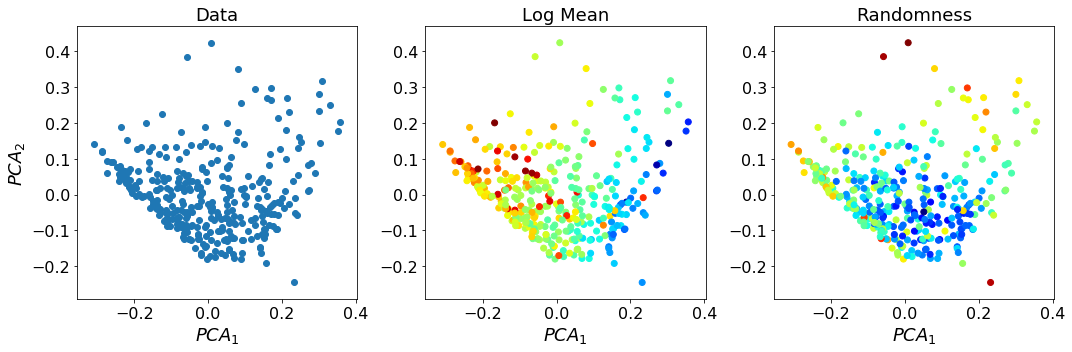

In [17]:
# PCA boyutlarını anlamlandırdığımız değişkenlere göre renklendirelim. 

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].set_title('Data', fontsize=18)
axes[0].scatter(tfd[:, 0], tfd[:, 1])
axes[0].set_xlabel('${PCA}_1$', fontsize=18)
axes[0].set_ylabel('${PCA}_2$', fontsize=18)
axes[0].tick_params(labelsize=16)

axes[1].set_title('Log Mean', fontsize=18)
axes[1].scatter(tfd[:, 0], tfd[:, 1], c=np.log10(list(code_to_means.values())), cmap='jet')
axes[1].set_xlabel('${PCA}_1$', fontsize=18)
axes[1].tick_params(labelsize=16)

hists = np.array(list(code_to_hist.values()))

axes[2].set_title('Randomness', fontsize=18)
axes[2].scatter(tfd[:, 0], tfd[:, 1], c=entropy(hists), cmap='jet')
axes[2].set_xlabel('${PCA}_1$', fontsize=18)
axes[2].tick_params(labelsize=16)
fig.tight_layout()

In [18]:
from sklearn.cluster import KMeans, SpectralClustering

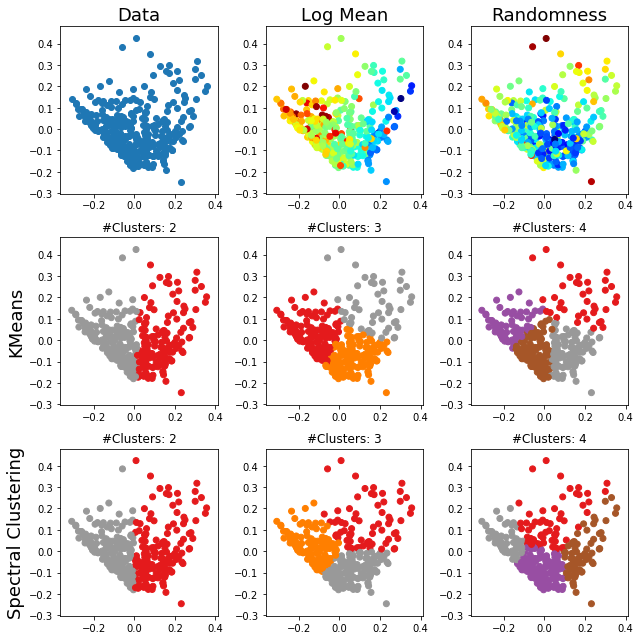

In [19]:
# Elimizdeki PCA verisini farklı kümeleme algoritmalarıyla sınıflandıralım.

fig, axes = plt.subplots(3, 3, figsize=(9, 9))

axes[0, 0].set_title('Data', fontsize=18)
axes[0, 0].scatter(tfd[:, 0], tfd[:, 1])
#axes[0, 0].set_xlabel('${PCA}_1$', fontsize=18)
#axes[0, 0].set_ylabel('${PCA}_2$', fontsize=18)
#axes[0, 0].tick_params(labelsize=16)

axes[0, 1].set_title('Log Mean', fontsize=18)
axes[0, 1].scatter(tfd[:, 0], tfd[:, 1], c=np.log10(list(code_to_means.values())), cmap='jet')
#axes[0, 1].set_xlabel('${PCA}_1$', fontsize=18)
#axes[0, 1].tick_params(labelsize=16)

hists = np.array(list(code_to_hist.values()))

axes[0, 2].set_title('Randomness', fontsize=18)
axes[0, 2].scatter(tfd[:, 0], tfd[:, 1], c=entropy(hists), cmap='jet')
#axes[0, 2].set_xlabel('${PCA}_1$', fontsize=18)
#axes[0, 2].tick_params(labelsize=16)

axes[1, 0].set_ylabel('KMeans', fontsize=18)
axes[2, 0].set_ylabel('Spectral Clustering', fontsize=18)
for i, n_comps in enumerate([2, 3, 4]):
    labels = KMeans(n_clusters=n_comps, random_state=random_state).fit(tfd).labels_
    axes[1, i].set_title('#Clusters: %d' % n_comps)
    axes[1, i].scatter(tfd[:, 0], tfd[:, 1], c=labels, cmap='Set1')
    
for i, n_comps in enumerate([2, 3, 4]):
    labels = SpectralClustering(n_clusters=n_comps, random_state=random_state, assign_labels='discretize').fit(tfd).labels_
    axes[2, i].set_title('#Clusters: %d' % n_comps)
    axes[2, i].scatter(tfd[:, 0], tfd[:, 1], c=labels, cmap='Set1')
fig.tight_layout()

In [20]:
interval_labels = labels.copy()

In [21]:
cluster0, = np.where(labels == 0)
cluster1, = np.where(labels == 1)
cluster2, = np.where(labels == 2)
cluster3, = np.where(labels == 3)

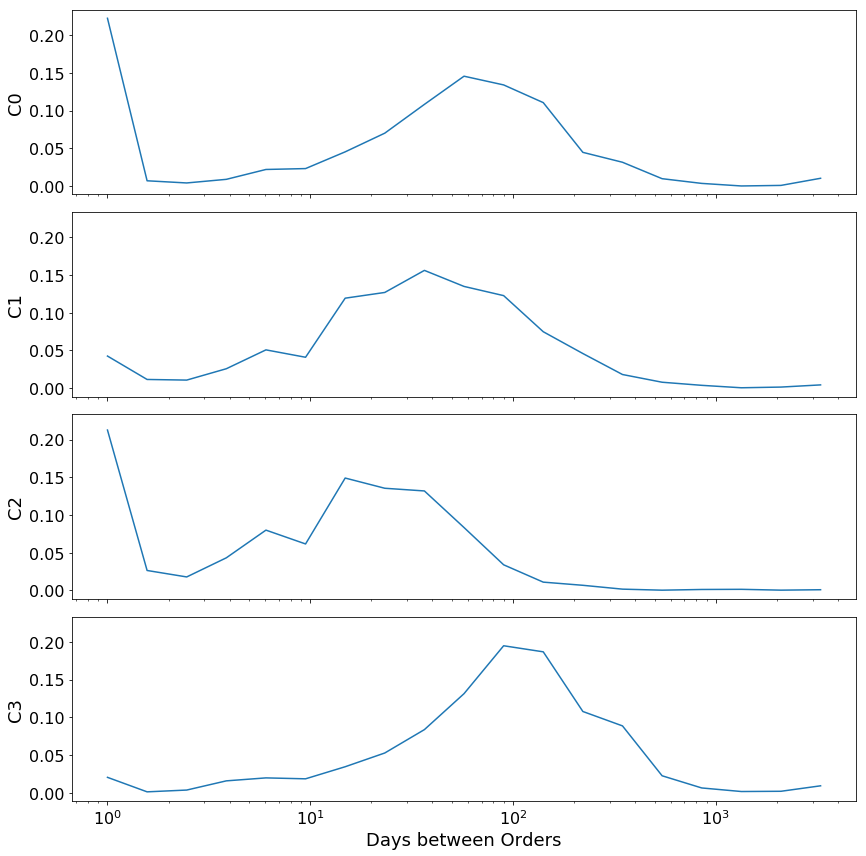

In [22]:
# Her bir kümenin neyi ifade ettiğini anlamak için kümenin ortalama histogramına bakalım.
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True, sharey=True)
axes[0].semilogx(_[:-1], hists[cluster0, :].mean(axis=0))
axes[0].set_ylabel('C0', fontsize=18)

axes[1].semilogx(_[:-1], hists[cluster1, :].mean(axis=0))
axes[1].set_ylabel('C1', fontsize=18)

axes[2].semilogx(_[:-1], hists[cluster2, :].mean(axis=0))
axes[2].set_ylabel('C2', fontsize=18)

axes[3].semilogx(_[:-1], hists[cluster3, :].mean(axis=0))
axes[3].set_ylabel('C3', fontsize=18)
axes[-1].set_xlabel('Days between Orders', fontsize=18)
[ax.tick_params(labelsize=16) for ax in axes]
fig.tight_layout()

In [23]:
# Küme isimlerini anlamlandıralım.
name_c0= 'STALE UNSTABLE'
name_c1 = 'FREQUENT STABLE'
name_c2 = 'FREQUENT UNSTABLE'
name_c3 = 'STALE STABLE'

In [24]:
# Satış sıklığı için yaptığımız işlemleri şimdi de aylık satış dağılımı üzerinde yapalım.
month_transform = PCA(n_components=2).fit_transform(np.array(list(code_to_months.values())))

In [27]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

[ 0.11111111  0.          0.          0.          0.          0.
  0.11111111  0.          0.11111111  0.11111111  0.22222222  0.11111111
  0.11111111  0.          0.          0.          0.          0.
  0.11111111]


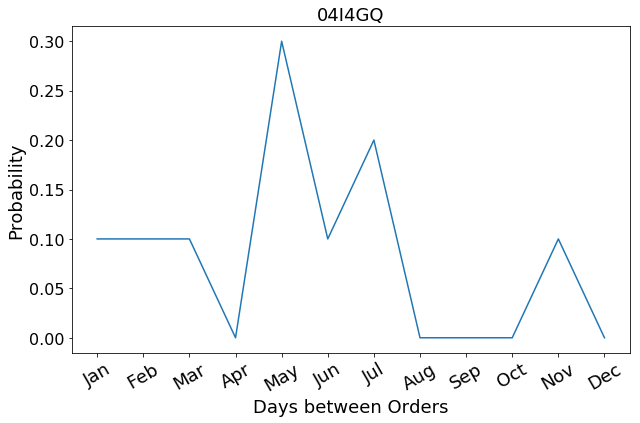

In [43]:
# 04I4GQ ürününün satış histogramını görselleştirelim.
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(12), code_to_months['04I4GQ'])
ax.tick_params(labelsize=16)
ax.set_ylabel('Probability', fontsize=18)
ax.set_xlabel('Days between Orders', fontsize=18)
ax.set_title('04I4GQ', fontsize=18)
ax.set_xticks(range(12))
ax.set_xticklabels(months, fontsize=18, rotation=30)
print(code_to_hist['04I4GQ'])

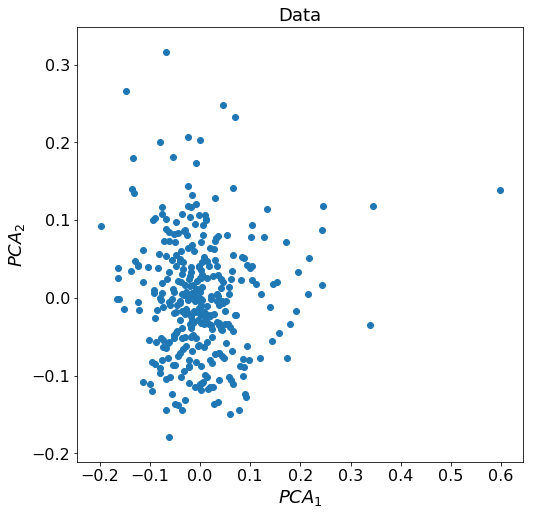

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_title('Data', fontsize=18)
ax.scatter(month_transform[:, 0], month_transform[:, 1])
ax.set_xlabel('${PCA}_1$', fontsize=18)
ax.set_ylabel('${PCA}_2$', fontsize=18)
ax.tick_params(labelsize=16)

In [26]:
highs_y, = np.where(month_transform[:, 1] > 0.1)
lows_y, = np.where(month_transform[:, 1] < -0.1) 
highs_x, = np.where(month_transform[:, 0] > 0.1)
lows_x, = np.where(month_transform[:, 0] < -0.1) 

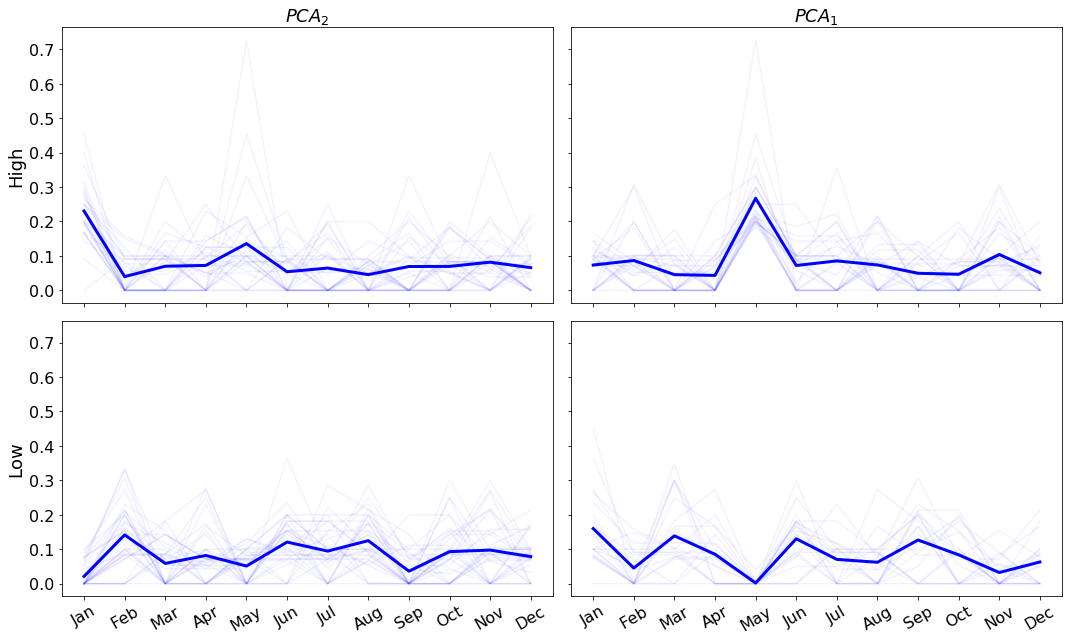

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 9), sharex=True, sharey=True)
axes[0, 0].set_title('${PCA}_2$', fontsize=18)
axes[0, 1].set_title('${PCA}_1$', fontsize=18)
axes[0, 0].set_ylabel('High', fontsize=18)
axes[1, 0].set_ylabel('Low', fontsize=18)
highy_mean = np.zeros((12,))
lowy_mean = np.zeros((12,))
highx_mean = np.zeros((12,))
lowx_mean = np.zeros((12,))

for high in highs_y:
    vec = code_to_months[keys[high]]
    highy_mean += vec / len(highs_y)
    axes[0, 0].plot(np.arange(12), vec, c='b', alpha=0.05)
axes[0, 0].plot(np.arange(12), highy_mean, c='b', alpha=1, linewidth=3)

for low in lows_y:
    vec = code_to_months[keys[low]]
    lowy_mean += vec / len(lows_y)
    axes[1, 0].plot(np.arange(12), vec, c='b', alpha=0.05)
axes[1, 0].plot(np.arange(12), lowy_mean, c='b', alpha=1, linewidth=3)

for high in highs_x:
    vec = code_to_months[keys[high]]
    highx_mean += vec / len(highs_x)
    axes[0, 1].plot(np.arange(12), vec, c='b', alpha=0.05)
axes[0, 1].plot(np.arange(12), highx_mean, c='b', alpha=1, linewidth=3)

for low in lows_x:
    vec = code_to_months[keys[low]]
    lowx_mean += vec / len(lows_x)
    axes[1, 1].plot(np.arange(12), vec, c='b', alpha=0.05)
axes[1, 1].plot(np.arange(12), lowx_mean, c='b', alpha=1, linewidth=3)
[ax.set_xticks(range(12)) for ax in axes[1, :]]
[ax.set_xticklabels(months, fontsize=18, rotation=30) for ax in axes[1, :]]
__ = [ax.tick_params(labelsize=16) for ax in axes.reshape(-1)]
fig.tight_layout()

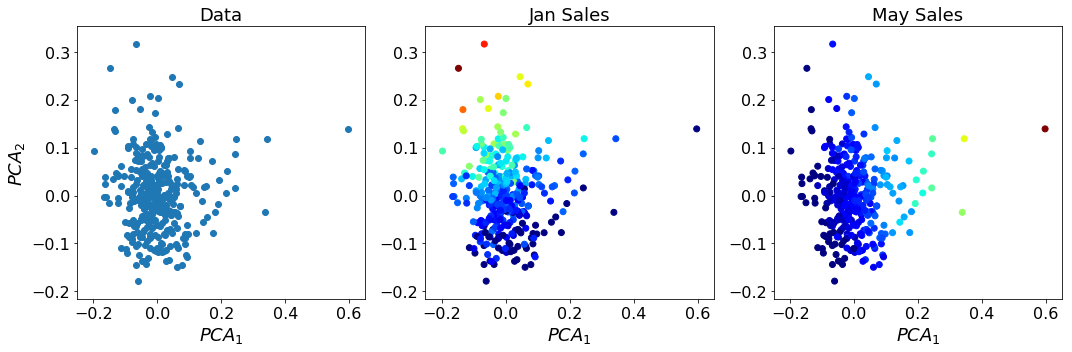

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].set_title('Data', fontsize=18)
axes[0].scatter(month_transform[:, 0], month_transform[:, 1])
axes[0].set_xlabel('${PCA}_1$', fontsize=18)
axes[0].set_ylabel('${PCA}_2$', fontsize=18)
axes[0].tick_params(labelsize=16)

axes[1].set_title('Jan Sales', fontsize=18)
axes[1].scatter(month_transform[:, 0], month_transform[:, 1], c=np.array(list(code_to_months.values()))[:, 0], cmap='jet')
axes[1].set_xlabel('${PCA}_1$', fontsize=18)
axes[1].tick_params(labelsize=16)

hists = np.array(list(code_to_hist.values()))

axes[2].set_title('May Sales', fontsize=18)
axes[2].scatter(month_transform[:, 0], month_transform[:, 1], c=np.array(list(code_to_months.values()))[:, 4], cmap='jet')
axes[2].set_xlabel('${PCA}_1$', fontsize=18)
axes[2].tick_params(labelsize=16)
fig.tight_layout()

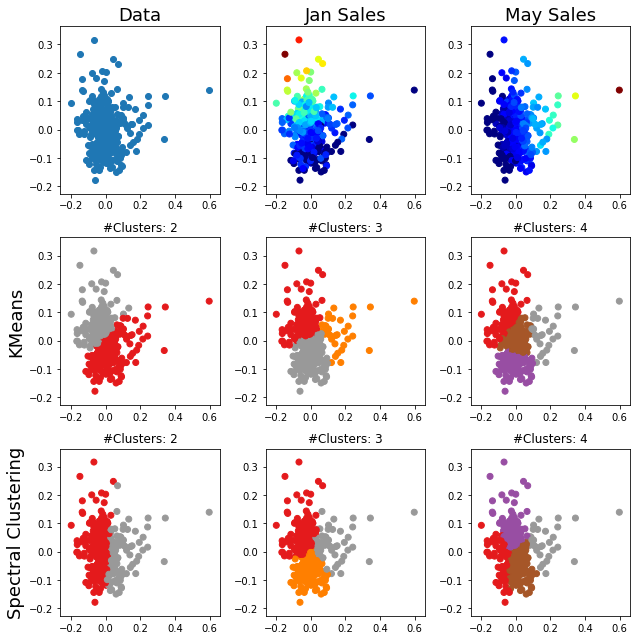

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

axes[0, 0].set_title('Data', fontsize=18)
axes[0, 0].scatter(month_transform[:, 0], month_transform[:, 1])
#axes[0, 0].set_xlabel('${PCA}_1$', fontsize=18)
#axes[0, 0].set_ylabel('${PCA}_2$', fontsize=18)
#axes[0, 0].tick_params(labelsize=16)

axes[0, 1].set_title('Jan Sales', fontsize=18)
axes[0, 1].scatter(month_transform[:, 0], month_transform[:, 1], c=np.array(list(code_to_months.values()))[:, 0], cmap='jet')
#axes[0, 1].set_xlabel('${PCA}_1$', fontsize=18)
#axes[0, 1].tick_params(labelsize=16)

hists = np.array(list(code_to_hist.values()))

axes[0, 2].set_title('May Sales', fontsize=18)
axes[0, 2].scatter(month_transform[:, 0], month_transform[:, 1], c=np.array(list(code_to_months.values()))[:, 4], cmap='jet')
#axes[0, 2].set_xlabel('${PCA}_1$', fontsize=18)
#axes[0, 2].tick_params(labelsize=16)

axes[1, 0].set_ylabel('KMeans', fontsize=18)
axes[2, 0].set_ylabel('Spectral Clustering', fontsize=18)
for i, n_comps in enumerate([2, 3, 4]):
    labels = KMeans(n_clusters=n_comps, random_state=random_state).fit(month_transform).labels_
    axes[1, i].set_title('#Clusters: %d' % n_comps)
    axes[1, i].scatter(month_transform[:, 0], month_transform[:, 1], c=labels, cmap='Set1')
    
for i, n_comps in enumerate([2, 3, 4]):
    labels = SpectralClustering(n_clusters=n_comps, random_state=random_state, assign_labels='discretize').fit(month_transform).labels_
    axes[2, i].set_title('#Clusters: %d' % n_comps)
    axes[2, i].scatter(month_transform[:, 0], month_transform[:, 1], c=labels, cmap='Set1')
fig.tight_layout()

In [31]:
month_labels = SpectralClustering(n_clusters=3, random_state=random_state, assign_labels='discretize').fit(month_transform).labels_

In [32]:
mcluster0, = np.where(month_labels == 0)
mcluster1, = np.where(month_labels == 1)
mcluster2, = np.where(month_labels == 2)

In [33]:
hists = np.array(list(code_to_months.values()))

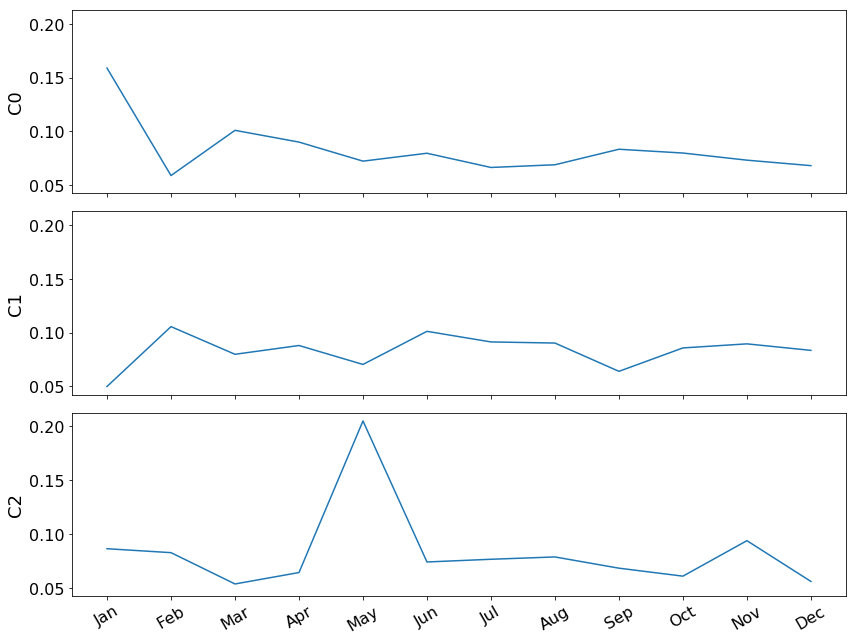

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True, sharey=True)
axes[0].plot(range(12), hists[mcluster0, :].mean(axis=0))
axes[0].set_ylabel('C0', fontsize=18)

axes[1].plot(range(12), hists[mcluster1, :].mean(axis=0))
axes[1].set_ylabel('C1', fontsize=18)

axes[2].plot(range(12), hists[mcluster2, :].mean(axis=0))
axes[2].set_ylabel('C2', fontsize=18)

[ax.set_xticks(range(12)) for ax in axes]
[ax.tick_params(labelsize=16) for ax in axes]
[ax.set_xticklabels(months, fontsize=16, rotation=30) for ax in axes]

fig.tight_layout()

In [35]:
name_cm0 = 'HIGH IN JAN'
name_cm1 = 'UNIFORM'
name_cm2 = 'HIGH IN MAY'

$$E[X] = \sum_{x \in X} x P(X=x)$$

In [36]:
# Her ürünün ortalama satış değerini bulmak için normalize histogram ile
# histogram aralıklarını çarpıyoruz.

expected_order_intervals = np.array(list(code_to_hist.values())).dot(interval[:-1])

In [37]:
# Her ürünü ait olduğu satış sıklığı kümesine atayalım.
interval_clusters = []
loyalty_clusters = []
for i in range(len(code_to_hist.keys())):
    c_idx = interval_labels[i]
    name = None
    if c_idx == 0:
        [frequency, loyalty] = name_c0.split(' ')
    elif c_idx == 1:
        [frequency, loyalty] = name_c1.split(' ')
    elif c_idx == 2:
        [frequency, loyalty] = name_c2.split(' ')
    else:
        [frequency, loyalty] = name_c3.split(' ')
    interval_clusters.append(frequency)
    loyalty_clusters.append(loyalty)

In [38]:
# Her ürünü ait olduğu aylık kümeye atayalım.
month_clusters = []
for i in range(len(code_to_hist.keys())):
    c_idx = month_labels[i]
    name = None
    if c_idx == 0:
        name = name_cm0
    elif c_idx == 1:
        name = name_cm1
    else:
        name = name_cm2
    month_clusters.append(name)

In [39]:
# Tablolayalım.
frame = {'Avg. Time Between Orders': expected_order_intervals,
      'Seasonality': month_clusters,
      'Frequency': interval_clusters,
      'Loyalty': loyalty_clusters}
products = pd.DataFrame(frame, index=list(code_to_hist.keys()))
products.head()

,Avg. Time Between Orders,Seasonality,Frequency,Loyalty
04I4GQ,437.145353,HIGH IN MAY,STALE,UNSTABLE
04IWQQ,134.434122,HIGH IN JAN,FREQUENT,UNSTABLE
0RIR84,133.660536,UNIFORM,STALE,STABLE
0WIQQ4,403.996385,UNIFORM,STALE,STABLE
0WIRQQ,19.227190,UNIFORM,FREQUENT,UNSTABLE


In [40]:
# Düzenli olarak sık satılan on ürünü ortalama satış sıklığına göre sıralayalım.
products[(products.Loyalty == 'STABLE') & (products.Frequency == 'FREQUENT')]\
    .sort_values('Avg. Time Between Orders').head(10)

,Avg. Time Between Orders,Seasonality,Frequency,Loyalty
E2IIQR,24.321994,HIGH IN JAN,FREQUENT,STABLE
EGIQYG,26.876818,HIGH IN JAN,FREQUENT,STABLE
EGI2WY,26.904542,UNIFORM,FREQUENT,STABLE
5CWMSR,29.223910,HIGH IN JAN,FREQUENT,STABLE
E2IGRI,29.502169,HIGH IN MAY,FREQUENT,STABLE
E2I8IW,29.620635,UNIFORM,FREQUENT,STABLE
E2IYIY,30.083916,HIGH IN JAN,FREQUENT,STABLE
E2IQ8W,32.082637,HIGH IN JAN,FREQUENT,STABLE
E2IGR2,32.786613,HIGH IN JAN,FREQUENT,STABLE
E2IIFF,34.064221,UNIFORM,FREQUENT,STABLE
